# Meli Customer Behavior Prediction
This project aims to predict customer purchasing behavior using machine learning models on a dataset from Meli, an e-commerce platform. The project utilizes various machine learning algorithms to analyze user history and item data to forecast which items a user is likely to purchase.

In [1]:
# Installation
!pip install xgboost lightgbm catboost shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.6 MB/s eta 0:00:00


In [2]:
# Importing libraries

# Standard libraries
from collections import Counter
from datetime import datetime
from dateutil.parser import isoparse
import json
import os

# Third-party libraries
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
import shap

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Machine learning libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [3]:
# Mapeia diretório de uso
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/Meli')

Mounted at /content/drive


In [4]:
# Data Loading: train_data
train_data = pd.read_json("input/train_dataset.jl", lines=True, orient='columns')
#train_data.head(2)

In [5]:
# Data Loading: item_data
item_data = pd.read_json("input/item_data.jl", lines=True, orient='columns')
item_data.head(10)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800.0,1392.83,MLM151595,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,NaN,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,NaN,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,NaN,1599.00,MLM1652,used
5,534737,Transmisor Fm Sin Hilos Bluetooth Reproductor ...,MLM-VEHICLE_ACCESSORIES,NaN,470.00,MLM92472,new
6,369182,Funda Cartera Caseme 007 2 En 1 Huawei P30 Pro,MLM-CELLPHONE_COVERS,NaN,589.00,MLM167442,new
7,690585,Lampara De Techo Tubo Slim Led Base G5 9w Blan...,MLM-WALL_AND_CEILING_LIGHTS,NaN,184.00,MLM1588,new
8,890593,"Repisa Organizador Para Cocina, Especieros, T...",MLM-NAPKIN_HOLDERS,NaN,879.00,MLM167544,new
9,1786901,"Trío, Balerina, Cosmo, Leopardo/negro/rojo, Ve...",MLM-FLATS,NaN,729.00,MLM193197,new


In [6]:
item_data[item_data.item_id == 1587624]

,item_id,title,domain_id,product_id,price,category_id,condition
721826,1587624,Tampa Partida Completa Motosserra Stihl 08 Nov...,MLB-TOOL_ACCESSORIES_AND_SPARES,NaN,159.9,MLB271402,new


In [7]:
item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102277 entries, 0 to 2102276
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   item_id      int64  
 1   title        object 
 2   domain_id    object 
 3   product_id   float64
 4   price        float64
 5   category_id  object 
 6   condition    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 112.3+ MB


In [8]:
# Realizando o merge
merged_data = pd.merge(train_data, item_data, how='left', left_on='item_bought', right_on='item_id')
data = merged_data.copy()
# Carrega base reduzida
#merged_data = pd.read_csv('base_reduzida.csv')

# Visualizando o resultado
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413163 entries, 0 to 413162
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_history  413163 non-null  object 
 1   item_bought   413163 non-null  int64  
 2   item_id       413163 non-null  int64  
 3   title         413163 non-null  object 
 4   domain_id     413163 non-null  object 
 5   product_id    107497 non-null  float64
 6   price         413163 non-null  float64
 7   category_id   413163 non-null  object 
 8   condition     413163 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 28.4+ MB


In [9]:
merged_data['user_history']

0         [{'event_info': 1786148, 'event_timestamp': '2...
1         [{'event_info': 643652, 'event_timestamp': '20...
2         [{'event_info': 248595, 'event_timestamp': '20...
3         [{'event_info': 'RADIOBOSS', 'event_timestamp'...
4         [{'event_info': 'AMAZFIT BIP', 'event_timestam...
                                ...                        
413158    [{'event_info': 'PC GAMER', 'event_timestamp':...
413159    [{'event_info': 289961, 'event_timestamp': '20...
413160    [{'event_info': 'ALUGUEL BOB CAT', 'event_time...
413161    [{'event_info': 'XAOMI', 'event_timestamp': '2...
413162    [{'event_info': 'COTONETE FINO', 'event_timest...
Name: user_history, Length: 413163, dtype: object

In [10]:
# Função para converter user_history de string JSON para lista de dicionários
def parse_user_history(user_history):
    if isinstance(user_history, str):
        return json.loads(user_history.replace("'", '"'))
    return user_history

# Regressão Logística Multinomial

In [11]:
# Função para extrair features dos eventos
def extract_features(event_list):
    events = Counter([event['event_type'] for event in event_list])
    items_viewed = Counter([event['event_info'] for event in event_list if event['event_type'] == 'view'])
    searches = Counter([event['event_info'] for event in event_list if event['event_type'] == 'search'])

    # Total view time
    total_view_time = sum(event.get('event_duration', 0) for event in event_list if event['event_type'] == 'view')

    # Number of different items viewed
    num_distinct_items_viewed = len(set(event['event_info'] for event in event_list if event['event_type'] == 'view'))

    # Total number of events
    total_events = len(event_list)

    # Average view time per item
    avg_view_time_per_item = total_view_time / num_distinct_items_viewed if num_distinct_items_viewed > 0 else 0

    # Time between first and last event
    event_times = [isoparse(event['event_timestamp']) for event in event_list]
    time_span = (max(event_times) - min(event_times)).total_seconds() if event_times else 0

    # Number of purchase events
    num_purchases = events['purchase']

    # First and last item viewed
    first_item_viewed = next((event['event_info'] for event in event_list if event['event_type'] == 'view'), None)
    last_item_viewed = next((event['event_info'] for event in reversed(event_list) if event['event_type'] == 'view'), None)

    # Day of the week for first and last event
    first_event_day = isoparse(event_list[0]['event_timestamp']).weekday() if event_list else None
    last_event_day = isoparse(event_list[-1]['event_timestamp']).weekday() if event_list else None

    features = {
        'num_views': events['view'],
        'num_searches': events['search'],
        'most_viewed_item': items_viewed.most_common(1)[0][0] if items_viewed else None,
        'most_searched_item': searches.most_common(1)[0][0] if searches else None,
        'total_view_time': total_view_time,
        'num_distinct_items_viewed': num_distinct_items_viewed,
        'total_events': total_events,
        'avg_view_time_per_item': avg_view_time_per_item,
        'time_span': time_span,
        'num_purchases': num_purchases,
        'first_item_viewed': first_item_viewed,
        'last_item_viewed': last_item_viewed,
        'first_event_day': first_event_day,
        'last_event_day': last_event_day
    }
    return features

# Filtrar somente os itens mais vendidos
top_items = data['item_bought'].value_counts().head(10).index
filtered_data = data[data['item_bought'].isin(top_items)].copy()

# Aplicar a função de extração de features
filtered_data['parsed_history'] = filtered_data['user_history'].apply(parse_user_history)
features = filtered_data['parsed_history'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Codificar as colunas categóricas adicionais
le_first_event_day = LabelEncoder()
features_df['first_event_day'] = le_first_event_day.fit_transform(features_df['first_event_day'].astype(str))

le_last_event_day = LabelEncoder()
features_df['last_event_day'] = le_last_event_day.fit_transform(features_df['last_event_day'].astype(str))

# Codificar as colunas existentes
le_most_viewed = LabelEncoder()
le_most_searched = LabelEncoder()

features_df['most_viewed_item'] = le_most_viewed.fit_transform(features_df['most_viewed_item'].astype(str))
features_df['most_searched_item'] = le_most_searched.fit_transform(features_df['most_searched_item'].astype(str))

# Imputar valores NaN nas features
imputer = SimpleImputer(strategy='median')
features_df = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)

# Transformar as features em um formato adequado para o modelo
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(features_df.to_dict(orient='records'))
y = filtered_data['item_bought']

# Codificar os rótulos para que sejam valores inteiros sequenciais a partir de 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Regressão Logística Multinomial
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)
lr_model.fit(X_train, y_train)

# Avaliar o modelo de Regressão Logística Multinomial
y_pred_lr = lr_model.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.19421487603305784
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.08      0.13        77
           1       0.23      0.31      0.26        68
           2       0.25      0.26      0.26        69
           3       0.00      0.00      0.00        65
           4       0.20      0.28      0.23        57
           5       0.00      0.00      0.00        77
           6       0.14      0.59      0.23        86
           7       0.11      0.03      0.05        62
           8       0.30      0.36      0.33        75
           9       0.00      0.00      0.00        90

    accuracy                           0.19       726
   macro avg       0.17      0.19      0.15       726
weighted avg       0.17      0.19      0.15       726



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

# Random Forest

In [12]:
# Função para extrair features dos eventos
def extract_features(event_list):
    events = Counter([event['event_type'] for event in event_list])
    items_viewed = Counter([event['event_info'] for event in event_list if event['event_type'] == 'view'])
    searches = Counter([event['event_info'] for event in event_list if event['event_type'] == 'search'])

    # Total view time
    total_view_time = sum(event.get('event_duration', 0) for event in event_list if event['event_type'] == 'view')

    # Number of different items viewed
    num_distinct_items_viewed = len(set(event['event_info'] for event in event_list if event['event_type'] == 'view'))

    # Total number of events
    total_events = len(event_list)

    # Average view time per item
    avg_view_time_per_item = total_view_time / num_distinct_items_viewed if num_distinct_items_viewed > 0 else 0

    # Time between first and last event
    event_times = [isoparse(event['event_timestamp']) for event in event_list]
    time_span = (max(event_times) - min(event_times)).total_seconds() if event_times else 0

    # Number of purchase events
    num_purchases = events['purchase']

    # First and last item viewed
    first_item_viewed = next((event['event_info'] for event in event_list if event['event_type'] == 'view'), None)
    last_item_viewed = next((event['event_info'] for event in reversed(event_list) if event['event_type'] == 'view'), None)

    # Day of the week for first and last event
    first_event_day = isoparse(event_list[0]['event_timestamp']).weekday() if event_list else None
    last_event_day = isoparse(event_list[-1]['event_timestamp']).weekday() if event_list else None

    features = {
        'num_views': events['view'],
        'num_searches': events['search'],
        'most_viewed_item': items_viewed.most_common(1)[0][0] if items_viewed else None,
        'most_searched_item': searches.most_common(1)[0][0] if searches else None,
        'total_view_time': total_view_time,
        'num_distinct_items_viewed': num_distinct_items_viewed,
        'total_events': total_events,
        'avg_view_time_per_item': avg_view_time_per_item,
        'time_span': time_span,
        'num_purchases': num_purchases,
        'first_item_viewed': first_item_viewed,
        'last_item_viewed': last_item_viewed,
        'first_event_day': first_event_day,
        'last_event_day': last_event_day
    }
    return features

# Filtrar somente os itens mais vendidos
top_items = data['item_bought'].value_counts().head(10).index
filtered_data = data[data['item_bought'].isin(top_items)].copy()

# Aplicar a função de extração de features
filtered_data['parsed_history'] = filtered_data['user_history'].apply(parse_user_history)
features = filtered_data['parsed_history'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Função para buscar informações adicionais dos itens
def add_item_info(features_df, item_data, item_column_prefix):
    # Transformar os itens em int64
    features_df[item_column_prefix] = features_df[item_column_prefix].astype(float).astype('Int64')

    # Renomear colunas de item_data para evitar colisões
    item_data = item_data.rename(columns={
        'domain_id': f'{item_column_prefix}_domain_id',
        'price': f'{item_column_prefix}_price',
        'condition': f'{item_column_prefix}_condition'
    })

    # Merge para adicionar informações dos itens
    features_df = features_df.merge(item_data[['item_id', f'{item_column_prefix}_domain_id', f'{item_column_prefix}_price', f'{item_column_prefix}_condition']],
                                    left_on=item_column_prefix, right_on='item_id', how='left').drop(columns='item_id')

    return features_df

# Adicionar informações para most_viewed_item, first_item_viewed e last_item_viewed
features_df = add_item_info(features_df, item_data, 'most_viewed_item')
features_df = add_item_info(features_df, item_data, 'first_item_viewed')
features_df = add_item_info(features_df, item_data, 'last_item_viewed')

# Codificar as colunas categóricas adicionais
le_first_event_day = LabelEncoder()
features_df['first_event_day'] = le_first_event_day.fit_transform(features_df['first_event_day'].astype(str))

le_last_event_day = LabelEncoder()
features_df['last_event_day'] = le_last_event_day.fit_transform(features_df['last_event_day'].astype(str))

# Codificar as colunas existentes
le_most_viewed = LabelEncoder()
le_most_searched = LabelEncoder()

features_df['most_viewed_item'] = le_most_viewed.fit_transform(features_df['most_viewed_item'].astype(str))
features_df['most_searched_item'] = le_most_searched.fit_transform(features_df['most_searched_item'].astype(str))

# Codificar novas colunas categóricas
categorical_cols = ['most_viewed_item_domain_id', 'first_item_viewed_domain_id', 'last_item_viewed_domain_id',
                    'most_viewed_item_condition', 'first_item_viewed_condition', 'last_item_viewed_condition']
for col in categorical_cols:
    le = LabelEncoder()
    features_df[col] = le.fit_transform(features_df[col].astype(str))

# Imputar valores NaN nas features numéricas
imputer = SimpleImputer(strategy='median')
features_df = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)

# Transformar as features em um formato adequado para o modelo
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(features_df.to_dict(orient='records'))
y = filtered_data['item_bought']

# Codificar os rótulos para que sejam valores inteiros sequenciais a partir de 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5977961432506887
              precision    recall  f1-score   support

           0       0.54      0.51      0.52        77
           1       0.79      0.72      0.75        68
           2       0.98      0.93      0.96        69
           3       0.53      0.48      0.50        65
           4       0.72      0.74      0.73        57
           5       0.51      0.47      0.49        77
           6       0.39      0.64      0.49        86
           7       0.51      0.60      0.55        62
           8       0.61      0.55      0.58        75
           9       0.65      0.44      0.53        90

    accuracy                           0.60       726
   macro avg       0.63      0.61      0.61       726
weighted avg       0.62      0.60      0.60       726



# XGBoost

Accuracy: 0.5977961432506887
              precision    recall  f1-score   support

       10243       0.53      0.53      0.53        77
      548905       0.76      0.71      0.73        68
      716822       0.98      0.93      0.96        69
      725371       0.59      0.55      0.57        65
      859574       0.66      0.72      0.69        57
     1361154       0.56      0.45      0.50        77
     1587422       0.40      0.59      0.48        86
     1716388       0.59      0.60      0.59        62
     1803710       0.59      0.57      0.58        75
     1906937       0.53      0.42      0.47        90

    accuracy                           0.60       726
   macro avg       0.62      0.61      0.61       726
weighted avg       0.61      0.60      0.60       726



<Figure size 1000x800 with 0 Axes>

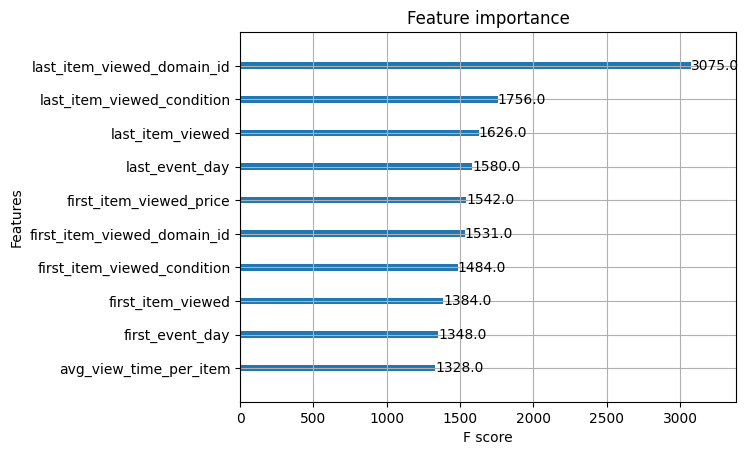

In [13]:
# Função para extrair features dos eventos
def extract_features(event_list):
    events = Counter([event['event_type'] for event in event_list])
    items_viewed = Counter([event['event_info'] for event in event_list if event['event_type'] == 'view'])
    searches = Counter([event['event_info'] for event in event_list if event['event_type'] == 'search'])

    # Total view time
    total_view_time = sum(event.get('event_duration', 0) for event in event_list if event['event_type'] == 'view')

    # Number of different items viewed
    num_distinct_items_viewed = len(set(event['event_info'] for event in event_list if event['event_type'] == 'view'))

    # Total number of events
    total_events = len(event_list)

    # Average view time per item
    avg_view_time_per_item = total_view_time / num_distinct_items_viewed if num_distinct_items_viewed > 0 else 0

    # Time between first and last event
    event_times = [isoparse(event['event_timestamp']) for event in event_list]
    time_span = (max(event_times) - min(event_times)).total_seconds() if event_times else 0

    # Number of purchase events
    num_purchases = events['purchase']

    # First and last item viewed
    first_item_viewed = next((event['event_info'] for event in event_list if event['event_type'] == 'view'), None)
    last_item_viewed = next((event['event_info'] for event in reversed(event_list) if event['event_type'] == 'view'), None)

    # Day of the week for first and last event
    first_event_day = isoparse(event_list[0]['event_timestamp']).weekday() if event_list else None
    last_event_day = isoparse(event_list[-1]['event_timestamp']).weekday() if event_list else None

    features = {
        'num_views': events['view'],
        'num_searches': events['search'],
        'most_viewed_item': items_viewed.most_common(1)[0][0] if items_viewed else None,
        'most_searched_item': searches.most_common(1)[0][0] if searches else None,
        'total_view_time': total_view_time,
        'num_distinct_items_viewed': num_distinct_items_viewed,
        'total_events': total_events,
        'avg_view_time_per_item': avg_view_time_per_item,
        'time_span': time_span,
        'num_purchases': num_purchases,
        'first_item_viewed': first_item_viewed,
        'last_item_viewed': last_item_viewed,
        'first_event_day': first_event_day,
        'last_event_day': last_event_day
    }
    return features

# Filtrar somente os itens mais vendidos
top_items = data['item_bought'].value_counts().head(10).index
filtered_data = data[data['item_bought'].isin(top_items)].copy()

# Aplicar a função de extração de features
filtered_data['parsed_history'] = filtered_data['user_history'].apply(parse_user_history)
features = filtered_data['parsed_history'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Função para buscar informações adicionais dos itens
def add_item_info(features_df, item_data, item_column_prefix):
    # Transformar os itens em int64
    features_df[item_column_prefix] = features_df[item_column_prefix].astype(float).astype('Int64')

    # Renomear colunas de item_data para evitar colisões
    item_data = item_data.rename(columns={
        'domain_id': f'{item_column_prefix}_domain_id',
        'price': f'{item_column_prefix}_price',
        'condition': f'{item_column_prefix}_condition'
    })

    # Merge para adicionar informações dos itens
    features_df = features_df.merge(item_data[['item_id', f'{item_column_prefix}_domain_id', f'{item_column_prefix}_price', f'{item_column_prefix}_condition']],
                                    left_on=item_column_prefix, right_on='item_id', how='left').drop(columns='item_id')

    return features_df

# Adicionar informações para most_viewed_item, first_item_viewed e last_item_viewed
features_df = add_item_info(features_df, item_data, 'most_viewed_item')
features_df = add_item_info(features_df, item_data, 'first_item_viewed')
features_df = add_item_info(features_df, item_data, 'last_item_viewed')

# Codificar as colunas categóricas adicionais
le_first_event_day = LabelEncoder()
features_df['first_event_day'] = le_first_event_day.fit_transform(features_df['first_event_day'].astype(str))

le_last_event_day = LabelEncoder()
features_df['last_event_day'] = le_last_event_day.fit_transform(features_df['last_event_day'].astype(str))

# Codificar as colunas existentes
le_most_viewed = LabelEncoder()
le_most_searched = LabelEncoder()

features_df['most_viewed_item'] = le_most_viewed.fit_transform(features_df['most_viewed_item'].astype(str))
features_df['most_searched_item'] = le_most_searched.fit_transform(features_df['most_searched_item'].astype(str))

# Codificar novas colunas categóricas
categorical_cols = ['most_viewed_item_domain_id', 'first_item_viewed_domain_id', 'last_item_viewed_domain_id',
                    'most_viewed_item_condition', 'first_item_viewed_condition', 'last_item_viewed_condition']
for col in categorical_cols:
    le = LabelEncoder()
    features_df[col] = le.fit_transform(features_df[col].astype(str))

# Imputar valores NaN nas features numéricas
imputer = SimpleImputer(strategy='median')
features_df = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)

# Transformar as features em um formato adequado para o modelo
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(features_df.to_dict(orient='records'))
y = filtered_data['item_bought']

# Codificar os rótulos para que sejam valores inteiros sequenciais a partir de 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)

# Decodificar os rótulos preditos para os valores originais
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

print('Accuracy:', accuracy_score(y_test_original, y_pred_original))
print(classification_report(y_test_original, y_pred_original))

# Obter nomes das características
feature_names = dv.get_feature_names_out()

# Plotar a importância das características
plt.figure(figsize=(10, 8))
ax = xgb.plot_importance(model, max_num_features=10, importance_type='weight')
ax.set_yticklabels([feature_names[int(idx)] for idx in ax.get_yticks()])
plt.title('Feature importance')
plt.show()


# LightGBM

In [14]:
# Função para extrair features dos eventos
def extract_features(event_list):
    events = Counter([event['event_type'] for event in event_list])
    items_viewed = Counter([event['event_info'] for event in event_list if event['event_type'] == 'view'])
    searches = Counter([event['event_info'] for event in event_list if event['event_type'] == 'search'])

    # Total view time
    total_view_time = sum(event.get('event_duration', 0) for event in event_list if event['event_type'] == 'view')

    # Number of different items viewed
    num_distinct_items_viewed = len(set(event['event_info'] for event in event_list if event['event_type'] == 'view'))

    # Total number of events
    total_events = len(event_list)

    # Average view time per item
    avg_view_time_per_item = total_view_time / num_distinct_items_viewed if num_distinct_items_viewed > 0 else 0

    # Time between first and last event
    event_times = [isoparse(event['event_timestamp']) for event in event_list]
    time_span = (max(event_times) - min(event_times)).total_seconds() if event_times else 0

    # Number of purchase events
    num_purchases = events['purchase']

    # First and last item viewed
    first_item_viewed = next((event['event_info'] for event in event_list if event['event_type'] == 'view'), None)
    last_item_viewed = next((event['event_info'] for event in reversed(event_list) if event['event_type'] == 'view'), None)

    # Day of the week for first and last event
    first_event_day = isoparse(event_list[0]['event_timestamp']).weekday() if event_list else None
    last_event_day = isoparse(event_list[-1]['event_timestamp']).weekday() if event_list else None

    features = {
        'num_views': events['view'],
        'num_searches': events['search'],
        'most_viewed_item': items_viewed.most_common(1)[0][0] if items_viewed else None,
        'most_searched_item': searches.most_common(1)[0][0] if searches else None,
        'total_view_time': total_view_time,
        'num_distinct_items_viewed': num_distinct_items_viewed,
        'total_events': total_events,
        'avg_view_time_per_item': avg_view_time_per_item,
        'time_span': time_span,
        'num_purchases': num_purchases,
        'first_item_viewed': first_item_viewed,
        'last_item_viewed': last_item_viewed,
        'first_event_day': first_event_day,
        'last_event_day': last_event_day
    }
    return features

# Filtrar somente os itens mais vendidos
top_items = data['item_bought'].value_counts().head(10).index
filtered_data = data[data['item_bought'].isin(top_items)].copy()

# Aplicar a função de extração de features
filtered_data['parsed_history'] = filtered_data['user_history'].apply(parse_user_history)
features = filtered_data['parsed_history'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Função para buscar informações adicionais dos itens
def add_item_info(features_df, item_data, item_column_prefix):
    # Transformar os itens em int64
    features_df[item_column_prefix] = features_df[item_column_prefix].astype(float).astype('Int64')

    # Renomear colunas de item_data para evitar colisões
    item_data = item_data.rename(columns={
        'domain_id': f'{item_column_prefix}_domain_id',
        'price': f'{item_column_prefix}_price',
        'condition': f'{item_column_prefix}_condition'
    })

    # Merge para adicionar informações dos itens
    features_df = features_df.merge(item_data[['item_id', f'{item_column_prefix}_domain_id', f'{item_column_prefix}_price', f'{item_column_prefix}_condition']],
                                    left_on=item_column_prefix, right_on='item_id', how='left').drop(columns='item_id')

    return features_df

# Adicionar informações para most_viewed_item, first_item_viewed e last_item_viewed
features_df = add_item_info(features_df, item_data, 'most_viewed_item')
features_df = add_item_info(features_df, item_data, 'first_item_viewed')
features_df = add_item_info(features_df, item_data, 'last_item_viewed')

# Codificar as colunas categóricas adicionais
le_first_event_day = LabelEncoder()
features_df['first_event_day'] = le_first_event_day.fit_transform(features_df['first_event_day'].astype(str))

le_last_event_day = LabelEncoder()
features_df['last_event_day'] = le_last_event_day.fit_transform(features_df['last_event_day'].astype(str))

# Codificar as colunas existentes
le_most_viewed = LabelEncoder()
le_most_searched = LabelEncoder()

features_df['most_viewed_item'] = le_most_viewed.fit_transform(features_df['most_viewed_item'].astype(str))
features_df['most_searched_item'] = le_most_searched.fit_transform(features_df['most_searched_item'].astype(str))

# Codificar novas colunas categóricas
categorical_cols = ['most_viewed_item_domain_id', 'first_item_viewed_domain_id', 'last_item_viewed_domain_id',
                    'most_viewed_item_condition', 'first_item_viewed_condition', 'last_item_viewed_condition']
for col in categorical_cols:
    le = LabelEncoder()
    features_df[col] = le.fit_transform(features_df[col].astype(str))

# Imputar valores NaN nas features numéricas
imputer = SimpleImputer(strategy='median')
features_df = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)

# Transformar as features em um formato adequado para o modelo
X = features_df
y = filtered_data['item_bought']

# Codificar os rótulos para que sejam valores inteiros sequenciais a partir de 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de LightGBM
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=len(top_items), random_state=42)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)

# Decodificar os rótulos preditos para os valores originais
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

print('Accuracy:', accuracy_score(y_test_original, y_pred_original))
print(classification_report(y_test_original, y_pred_original))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3235
[LightGBM] [Info] Number of data points in the train set: 2903, number of used features: 20
[LightGBM] [Info] Start training from score -2.289920
[LightGBM] [Info] Start training from score -2.338710
[LightGBM] [Info] Start training from score -2.408980
[LightGBM] [Info] Start training from score -2.424424
[LightGBM] [Info] Start training from score -2.393770
[LightGBM] [Info] Start training from score -2.456047
[LightGBM] [Info] Start training from score -1.816521
[LightGBM] [Info] Start training from score -2.405155
[LightGBM] [Info] Start training from score -2.240159
[LightGBM] [Info] Start training from score -2.436166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.6074380165

# Extra Trees Classifier

In [15]:
# Função para extrair features dos eventos
def extract_features(event_list):
    events = Counter([event['event_type'] for event in event_list])
    items_viewed = Counter([event['event_info'] for event in event_list if event['event_type'] == 'view'])
    searches = Counter([event['event_info'] for event in event_list if event['event_type'] == 'search'])

    # Total view time
    total_view_time = sum(event.get('event_duration', 0) for event in event_list if event['event_type'] == 'view')

    # Number of different items viewed
    num_distinct_items_viewed = len(set(event['event_info'] for event in event_list if event['event_type'] == 'view'))

    # Total number of events
    total_events = len(event_list)

    # Average view time per item
    avg_view_time_per_item = total_view_time / num_distinct_items_viewed if num_distinct_items_viewed > 0 else 0

    # Time between first and last event
    event_times = [isoparse(event['event_timestamp']) for event in event_list]
    time_span = (max(event_times) - min(event_times)).total_seconds() if event_times else 0

    # Number of purchase events
    num_purchases = events['purchase']

    # First and last item viewed
    first_item_viewed = next((event['event_info'] for event in event_list if event['event_type'] == 'view'), None)
    last_item_viewed = next((event['event_info'] for event in reversed(event_list) if event['event_type'] == 'view'), None)

    # Day of the week for first and last event
    first_event_day = isoparse(event_list[0]['event_timestamp']).weekday() if event_list else None
    last_event_day = isoparse(event_list[-1]['event_timestamp']).weekday() if event_list else None

    features = {
        'num_views': events['view'],
        'num_searches': events['search'],
        'most_viewed_item': items_viewed.most_common(1)[0][0] if items_viewed else None,
        'most_searched_item': searches.most_common(1)[0][0] if searches else None,
        'total_view_time': total_view_time,
        'num_distinct_items_viewed': num_distinct_items_viewed,
        'total_events': total_events,
        'avg_view_time_per_item': avg_view_time_per_item,
        'time_span': time_span,
        'num_purchases': num_purchases,
        'first_item_viewed': first_item_viewed,
        'last_item_viewed': last_item_viewed,
        'first_event_day': first_event_day,
        'last_event_day': last_event_day
    }
    return features

# Filtrar somente os itens mais vendidos
top_items = data['item_bought'].value_counts().head(10).index
filtered_data = data[data['item_bought'].isin(top_items)].copy()

# Aplicar a função de extração de features
filtered_data['parsed_history'] = filtered_data['user_history'].apply(parse_user_history)
features = filtered_data['parsed_history'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Função para buscar informações adicionais dos itens
def add_item_info(features_df, item_data, item_column_prefix):
    # Transformar os itens em int64
    features_df[item_column_prefix] = features_df[item_column_prefix].astype(float).astype('Int64')

    # Renomear colunas de item_data para evitar colisões
    item_data = item_data.rename(columns={
        'domain_id': f'{item_column_prefix}_domain_id',
        'price': f'{item_column_prefix}_price',
        'condition': f'{item_column_prefix}_condition'
    })

    # Merge para adicionar informações dos itens
    features_df = features_df.merge(item_data[['item_id', f'{item_column_prefix}_domain_id', f'{item_column_prefix}_price', f'{item_column_prefix}_condition']],
                                    left_on=item_column_prefix, right_on='item_id', how='left').drop(columns='item_id')

    return features_df

# Adicionar informações para most_viewed_item, first_item_viewed e last_item_viewed
features_df = add_item_info(features_df, item_data, 'most_viewed_item')
features_df = add_item_info(features_df, item_data, 'first_item_viewed')
features_df = add_item_info(features_df, item_data, 'last_item_viewed')

# Codificar as colunas categóricas adicionais
le_first_event_day = LabelEncoder()
features_df['first_event_day'] = le_first_event_day.fit_transform(features_df['first_event_day'].astype(str))

le_last_event_day = LabelEncoder()
features_df['last_event_day'] = le_last_event_day.fit_transform(features_df['last_event_day'].astype(str))

# Codificar as colunas existentes
le_most_viewed = LabelEncoder()
le_most_searched = LabelEncoder()

features_df['most_viewed_item'] = le_most_viewed.fit_transform(features_df['most_viewed_item'].astype(str))
features_df['most_searched_item'] = le_most_searched.fit_transform(features_df['most_searched_item'].astype(str))

# Codificar novas colunas categóricas
categorical_cols = ['most_viewed_item_domain_id', 'first_item_viewed_domain_id', 'last_item_viewed_domain_id',
                    'most_viewed_item_condition', 'first_item_viewed_condition', 'last_item_viewed_condition']
for col in categorical_cols:
    le = LabelEncoder()
    features_df[col] = le.fit_transform(features_df[col].astype(str))

# Imputar valores NaN nas features numéricas
imputer = SimpleImputer(strategy='median')
features_df = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)

# Transformar as features em um formato adequado para o modelo
X = features_df
y = filtered_data['item_bought']

# Codificar os rótulos para que sejam valores inteiros sequenciais a partir de 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Extra Trees Classifier
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliar o modelo
y_pred = model.predict(X_test)

# Decodificar os rótulos preditos para os valores originais
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

print('Accuracy:', accuracy_score(y_test_original, y_pred_original))
print(classification_report(y_test_original, y_pred_original))


Accuracy: 0.5537190082644629
              precision    recall  f1-score   support

       10243       0.58      0.52      0.55        77
      548905       0.75      0.62      0.68        68
      716822       0.95      0.91      0.93        69
      725371       0.37      0.34      0.35        65
      859574       0.57      0.75      0.65        57
     1361154       0.45      0.43      0.44        77
     1587422       0.40      0.58      0.47        86
     1716388       0.48      0.61      0.54        62
     1803710       0.54      0.49      0.51        75
     1906937       0.63      0.38      0.47        90

    accuracy                           0.55       726
   macro avg       0.57      0.56      0.56       726
weighted avg       0.57      0.55      0.55       726



# Catboost

In [16]:
# Função para extrair features dos eventos
def extract_features(event_list):
    events = Counter([event['event_type'] for event in event_list])
    items_viewed = Counter([event['event_info'] for event in event_list if event['event_type'] == 'view'])
    searches = Counter([event['event_info'] for event in event_list if event['event_type'] == 'search'])

    # Total view time
    total_view_time = sum(event.get('event_duration', 0) for event in event_list if event['event_type'] == 'view')

    # Number of different items viewed
    num_distinct_items_viewed = len(set(event['event_info'] for event in event_list if event['event_type'] == 'view'))

    # Total number of events
    total_events = len(event_list)

    # Average view time per item
    avg_view_time_per_item = total_view_time / num_distinct_items_viewed if num_distinct_items_viewed > 0 else 0

    # Time between first and last event
    event_times = [isoparse(event['event_timestamp']) for event in event_list]
    time_span = (max(event_times) - min(event_times)).total_seconds() if event_times else 0

    # Number of purchase events
    num_purchases = events['purchase']

    # First and last item viewed
    first_item_viewed = next((event['event_info'] for event in event_list if event['event_type'] == 'view'), None)
    last_item_viewed = next((event['event_info'] for event in reversed(event_list) if event['event_type'] == 'view'), None)

    # Day of the week for first and last event
    first_event_day = isoparse(event_list[0]['event_timestamp']).weekday() if event_list else None
    last_event_day = isoparse(event_list[-1]['event_timestamp']).weekday() if event_list else None

    features = {
        'num_views': events['view'],
        'num_searches': events['search'],
        'most_viewed_item': items_viewed.most_common(1)[0][0] if items_viewed else None,
        'most_searched_item': searches.most_common(1)[0][0] if searches else None,
        'total_view_time': total_view_time,
        'num_distinct_items_viewed': num_distinct_items_viewed,
        'total_events': total_events,
        'avg_view_time_per_item': avg_view_time_per_item,
        'time_span': time_span,
        'num_purchases': num_purchases,
        'first_item_viewed': first_item_viewed,
        'last_item_viewed': last_item_viewed,
        'first_event_day': first_event_day,
        'last_event_day': last_event_day
    }
    return features

# Filtrar somente os itens mais vendidos
top_items = data['item_bought'].value_counts().head(10).index
filtered_data = data[data['item_bought'].isin(top_items)].copy()

# Aplicar a função de extração de features
filtered_data['parsed_history'] = filtered_data['user_history'].apply(parse_user_history)
features = filtered_data['parsed_history'].apply(extract_features)
features_df = pd.DataFrame(features.tolist())

# Função para buscar informações adicionais dos itens
def add_item_info(features_df, item_data, item_column_prefix):
    # Transformar os itens em int64
    features_df[item_column_prefix] = features_df[item_column_prefix].astype(float).astype('Int64')

    # Renomear colunas de item_data para evitar colisões
    item_data = item_data.rename(columns={
        'domain_id': f'{item_column_prefix}_domain_id',
        'price': f'{item_column_prefix}_price',
        'condition': f'{item_column_prefix}_condition'
    })

    # Merge para adicionar informações dos itens
    features_df = features_df.merge(item_data[['item_id', f'{item_column_prefix}_domain_id', f'{item_column_prefix}_price', f'{item_column_prefix}_condition']],
                                    left_on=item_column_prefix, right_on='item_id', how='left').drop(columns='item_id')

    return features_df

# Adicionar informações para most_viewed_item, first_item_viewed e last_item_viewed
features_df = add_item_info(features_df, item_data, 'most_viewed_item')
features_df = add_item_info(features_df, item_data, 'first_item_viewed')
features_df = add_item_info(features_df, item_data, 'last_item_viewed')

# Codificar as colunas categóricas adicionais
le_first_event_day = LabelEncoder()
features_df['first_event_day'] = le_first_event_day.fit_transform(features_df['first_event_day'].astype(str))

le_last_event_day = LabelEncoder()
features_df['last_event_day'] = le_last_event_day.fit_transform(features_df['last_event_day'].astype(str))

# Codificar as colunas existentes
le_most_viewed = LabelEncoder()
le_most_searched = LabelEncoder()

features_df['most_viewed_item'] = le_most_viewed.fit_transform(features_df['most_viewed_item'].astype(str))
features_df['most_searched_item'] = le_most_searched.fit_transform(features_df['most_searched_item'].astype(str))

# Codificar novas colunas categóricas
categorical_cols = ['most_viewed_item_domain_id', 'first_item_viewed_domain_id', 'last_item_viewed_domain_id',
                    'most_viewed_item_condition', 'first_item_viewed_condition', 'last_item_viewed_condition']
for col in categorical_cols:
    le = LabelEncoder()
    features_df[col] = le.fit_transform(features_df[col].astype(str))

# Imputar valores NaN nas features numéricas
imputer = SimpleImputer(strategy='median')
features_df = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)

# Converter as colunas categóricas para strings
categorical_cols = ['most_viewed_item', 'most_searched_item', 'first_event_day', 'last_event_day',
                    'most_viewed_item_domain_id', 'first_item_viewed_domain_id', 'last_item_viewed_domain_id',
                    'most_viewed_item_condition', 'first_item_viewed_condition', 'last_item_viewed_condition']

for col in categorical_cols:
    features_df[col] = features_df[col].astype(str)

# Transformar as features em um formato adequado para o modelo
X = features_df
y = filtered_data['item_bought']

# Codificar os rótulos para que sejam valores inteiros sequenciais a partir de 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar variáveis categóricas para o CatBoost
categorical_features_indices = [i for i, col in enumerate(features_df.columns) if col in categorical_cols]

# Treinar o modelo de CatBoost
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', random_seed=42, verbose=False)
model.fit(X_train, y_train, cat_features=categorical_features_indices)

# Avaliar o modelo
y_pred = model.predict(X_test)

# Decodificar os rótulos preditos para os valores originais
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)

print('Accuracy:', accuracy_score(y_test_original, y_pred_original))
print(classification_report(y_test_original, y_pred_original))

'''
# Plotar os valores SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plotagem SHAP para importância das características
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features_df.columns)

'''


Accuracy: 0.5881542699724518
              precision    recall  f1-score   support

       10243       0.42      0.61      0.50        77
      548905       0.81      0.68      0.74        68
      716822       0.84      0.77      0.80        69
      725371       0.49      0.51      0.50        65
      859574       0.73      0.75      0.74        57
     1361154       0.57      0.52      0.54        77
     1587422       0.37      0.58      0.45        86
     1716388       0.61      0.60      0.60        62
     1803710       0.79      0.60      0.68        75
     1906937       0.73      0.37      0.49        90

    accuracy                           0.59       726
   macro avg       0.64      0.60      0.60       726
weighted avg       0.63      0.59      0.59       726



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'\n# Plotar os valores SHAP\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(X_test)\n\n# Plotagem SHAP para importância das características\nshap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features_df.columns)\n\n'